In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# load/print five SA-LTMR traces
for i in range(1,6):
    loaded_array = np.load('saltmr_trace{}.npy'.format(i))
    print(loaded_array)


In [ ]:
# create a raster plot of all five SA-LTMR traces
fig, ax = plt.subplots()

for i in range(1,6):
    loaded_array = np.load('saltmr_trace{}.npy'.format(i))

    # Plot spikes as vertical lines for each onset array
    ax.vlines(loaded_array, (i-1), (i), colors='b', linewidth=2, label='Neuron {}'.format(i))

# adjust the raster plot
ax.set_xlim(0, 0.6)  # x-axis limits
ax.set_ylim(0, 5)   # y-axis limits based on the number of neurons
ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Neuron')
ax.set_title('Raster Plot')

# Show the plot
plt.show()

In [ ]:
#Make do_out laser output for a given firing pattern from an empirical trace (i.e., trace_array)

#Extract spike onset times from "saltmr_trace4.npy"
trace_oi = 4
Fs = 30000
trace_array = np.load('saltmr_trace{}.npy'.format(trace_oi))
#print(trace_array)


## Five sets of 0.5 second trains of 0.3ms laser pulses in an empirically-observed SA-LTMR pattern. 
# 5 seconds off between trains.
laser_duration = 0.0003  # seconds
train_duration = 0.5 # seconds

rest_duration = 5 # seconds
start_buffer = 1 # seconds
trial_duration = (2* start_buffer) + (5 * (train_duration + rest_duration)) - rest_duration + 1
print(trial_duration)

do_out = np.zeros((2, int(Fs * trial_duration)), dtype=bool)
print(len(do_out[0])/Fs)

train_onsets = np.arange((start_buffer), (trial_duration), ((train_duration + rest_duration))) * Fs
print(train_onsets)

laser_onsets = np.round(trace_array * Fs).astype(int)
print(laser_onsets)

for train_onset in train_onsets:
    for laser_onset in laser_onsets:
        start_index = int(train_onset + laser_onset)
        end_index = int(start_index + (laser_duration * Fs))
        do_out[0, start_index:end_index] = True

# Plot the results
plt.figure(figsize=(10, 6))

# Plot the raster of the trace array firing pattern
plt.subplot(2, 1, 1)
plt.eventplot(trace_array, colors='black', linewidths=2)
plt.title('Trace Array Firing Pattern')
plt.xlabel('Time (seconds)')
plt.ylabel('Neuron Index')


# Plot the raster of do_out[0] events for the first few seconds
plt.subplot(2, 1, 2)
event_indices = np.where(do_out[0])[0]
plt.eventplot(event_indices[event_indices < trial_duration * Fs] / Fs, colors='black', linewidths=2)
plt.title('do_out[0] Events')
plt.xlabel('Time (seconds)')
plt.ylabel('Event Index')
plt.xlim(0, trial_duration)  # Adjust the xlim based on the desired time range

# # Plot vertical lines at every onset
# onset_indices = np.where(np.diff(do_out[0]) == 1)[0] + 1
# onset_times = onset_indices / Fs
# plt.vlines(onset_times, 0, 2, color='red', linestyle='--', label='Onset')

plt.legend()
plt.tight_layout()

plt.show()




In [3]:
from datetime import datetime 

settings = {
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'minV' : -.25, # in Volts. Minimum voltage for mirror
    'maxV' : .25, # in Volts. Maximum voltage for mirror
    'stepV' : .1, # in Volts. Increment of voltage to be stepped for mirror
    'time_per_region' : 0.01 # in seconds. Duration to hold mirrors in place for each region
}


current_date = datetime.now()
date = current_date.strftime('%Y%m%d_%H%M%S')

np.save("C:/Users/aewor/settings_acRecField_{}.npy".format(date), settings)


This experiment will take 4.53 minutes to complete...


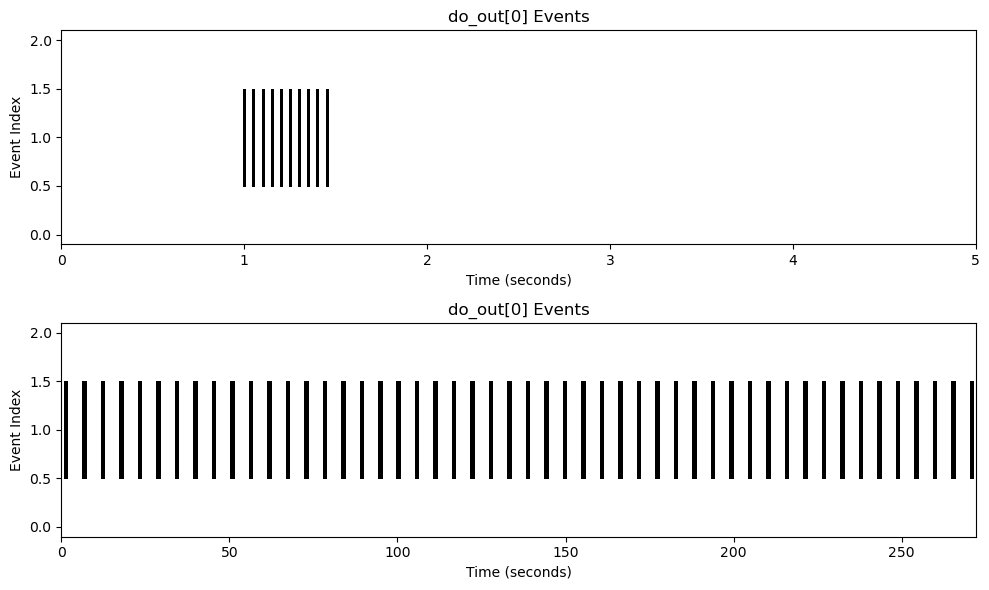

In [8]:
settings = {
    'xMirror_output': 'PXI1Slot2/ao0',
    'yMirror_output': 'PXI1Slot2/ao1',
    'laser_output': '/PXI1Slot2/port0/line0',
    'sync': '/PXI1Slot2/port0/line1', #output to trigger NP recording

    'Fs': 30000,  # in samples/s
    'xV' : -.25, # in Volts. Fixed voltage for mirror's x-axis
    'yV' : .25, # in Volts. Fixed voltage for mirror's y-axis

    'laser_duration' : 0.0003,  # seconds
    'laser_frequency' : 20, # Hz (for sustained pulse, equate to settings['Fs'])
    'train_duration' : 0.5, # seconds
    'rest_duration' : 5, # seconds
    'trial_buffer' : 1, # seconds
    'trial_repeats' : 50 # number of trains to pulse
}

trial_duration = (2 * settings['trial_buffer']) + (settings['trial_repeats'] * (settings['train_duration'] + settings['rest_duration'])) - settings['rest_duration']
minutes = round(trial_duration/60, 2)
print("This experiment will take {} minutes to complete...".format(minutes))

# initialize zeroed-out arrays
numSamples = int(settings['Fs'] * trial_duration)
ao_out = np.zeros((2, numSamples))
do_out = np.zeros((2, int(settings['Fs'] * trial_duration)), dtype=bool)

# Fill ao_out with mirror coordinates
ao_out[0] = np.full(1, settings["xV"])
ao_out[1] = np.full(1, settings["yV"])

# generate a train of laser pulses for settings['laser_duration']seconds at settings['laser_frequency']Hz    
train_onsets = np.arange((settings['trial_buffer']), (trial_duration), ((settings['train_duration'] + settings['rest_duration']))) * settings['Fs']
# Calculate the time points for laser onset within a train
laser_onsets = np.arange(0, settings['train_duration'], 1 / settings['laser_frequency'])
# Convert the time points to sample indices
laser_onsets = (laser_onsets * settings['Fs']).astype(int)

for train_onset in train_onsets:
    for laser_onset in laser_onsets:
        start_index = int(train_onset + laser_onset)
        end_index = int(start_index + (settings['laser_duration'] * settings['Fs']))
        do_out[0, start_index:end_index] = True



# Plot the results
plt.figure(figsize=(10, 6))

# Plot the raster of do_out[0] events for the first few seconds
plt.subplot(2, 1, 1)
event_indices = np.where(do_out[0])[0]
plt.eventplot(event_indices[event_indices < trial_duration * settings['Fs']] / settings['Fs'], colors='black', linewidths=2)
plt.title('do_out[0] Events')
plt.xlabel('Time (seconds)')
plt.ylabel('Event Index')
plt.xlim(0, 5)  # Adjust the xlim based on the desired time range

# Plot the raster of do_out[0] events for the first few seconds
plt.subplot(2, 1, 2)
event_indices = np.where(do_out[0])[0]
plt.eventplot(event_indices[event_indices < trial_duration * settings['Fs']] / settings['Fs'], colors='black', linewidths=2)
plt.title('do_out[0] Events')
plt.xlabel('Time (seconds)')
plt.ylabel('Event Index')
plt.xlim(0, trial_duration)  # Adjust the xlim based on the desired time range



#plt.legend()
plt.tight_layout()

plt.show()

